In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
# from cnn_image_classifier import CNNImageClassifier
from image_classifier import MultiScoreImageClassifier
import cv2
from time import time
from tqdm import tqdm
from PIL import Image

# import AutoImage
# from transformers import AutoImageProcessor, SuperPointForKeypointDetection, AutoModel
# import torch

from matplotlib import pyplot as plt

# Data Setup 

In [15]:
labels = pd.read_csv('../static/data/labels.csv')

ref_path = '../static/icon_ref_low_res' 
refs = ['darkness','discover','enlightenment']
ref_paths = [f'{ref_path}/{f}.png' for f in refs]

feed_path = '../static/data/img/'
feed_paths = [f'{feed_path}/{f}' for f in os.listdir(feed_path)]

## Predictions

## Color + Shape similarity

In [16]:
classifier = MultiScoreImageClassifier(
    reference_images=ref_paths, 
    bbox_scale_factor=2.0,
    min_bbox_area_threshold=100,
    max_bbox_area_threshold=2000,
    ratio_threshold=2.0,
    )
results = []
for input_path in tqdm(feed_paths):
    input_image = cv2.imread(input_path)
    # focus area
    height, width = input_image.shape[:2]
    crop_height = int(height * 0.5)
    crop_width = int(width * 0.8)
    input_image = input_image[crop_height:, crop_width:]
    # rotate image
    input_image = cv2.rotate(input_image, cv2.ROTATE_180)

    # plt.imshow(input_image)
    # plt.show()
    
    # Predict
    start_time = time()
    scores, detailed = classifier.classify(input_image)
    if detailed is None:
        out = {}
    else: 
        out = scores
    end_time = time()
    out['img_num'] = int(os.path.basename(input_path).split('.')[0])
    out['time'] = end_time - start_time
    results.append(out)

results_df = pd.DataFrame(results)
results_df = results_df.merge(labels, on='img_num', how='left')

100%|██████████| 28/28 [00:00<00:00, 247.48it/s]


In [17]:
def find_winner(row, labels_lst):
    scores = row[labels_lst]
    if scores.isnull().all():
        return 'none'
    winner_idx = np.argmax(list(row[labels_lst]))
    return labels_lst[winner_idx]

results_df['winner'] = results_df.apply(lambda row: find_winner(row, refs), axis=1)
results_df.drop(columns=['time','chapter_label'])

,img_num,darkness,discover,enlightenment,page_label,winner
0,8176,NaN,NaN,NaN,none,none
1,8177,NaN,NaN,NaN,none,none
2,8178,NaN,NaN,NaN,none,none
3,8179,0.636717,-0.156742,-0.082124,dark,darkness
4,8180,0.793479,-0.161858,-0.076891,dark,darkness
5,8181,0.693411,-0.208477,-0.117966,dark,darkness
6,8190,-0.042131,0.436417,0.783659,enlight,enlightenment
7,8191,0.011067,0.412958,0.482379,enlight,enlightenment
8,8192,NaN,NaN,NaN,none,none
9,8193,NaN,NaN,NaN,none,none


In [9]:
gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
gray.mean()

np.float64(12.876708984375)

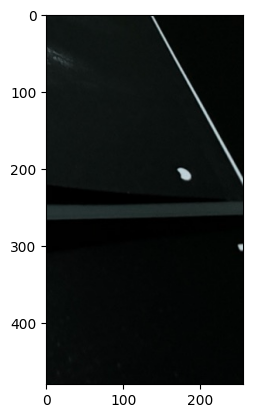

In [41]:
input_path = feed_path +'/8205.jpeg'
# focus area
input_image = cv2.imread(input_path)
height, width = input_image.shape[:2]
crop_height = int(height * 0.5)
crop_width = int(width * 0.8)
cropped_img = input_image[crop_height:, crop_width:]
# rotate image
input_image = cv2.rotate(input_image, cv2.ROTATE_180)


plt.imshow(cropped_img)

## Deep

In [ ]:
# check device vram
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

torch.backends.mps.is_available()


Using device: mps


True

In [77]:
ref_path = '../static/chapter_ref/'
ref_files = ["darkness.jpeg", "discover.jpeg", "enlightenment.jpeg"]

# ref_path = '../static/archive/icon/'
# ref_files = ["darkness.png", "discover.png", "enlightenment.png"]

ref_imgs = [os.path.join(ref_path, f) for f in ref_files]
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
classifier = CNNImageClassifier(reference_images=ref_imgs, device=device)

results = []
for index, row in tqdm(labels.iterrows(), total=labels.shape[0]):
    fake_feed_img = row['img_num']
    img_path = f'../static/data/img/{fake_feed_img}.jpeg'
    frame = cv2.imread(img_path)
    # flip image 180 degrees
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    start = time()
    best, scores = classifier.classify(frame)
    end = time()
    data = {
        'img_num': fake_feed_img,
        'dark': scores[classifier.reference_names[0]],
        'discover': scores[classifier.reference_names[1]],
        'enlight': scores[classifier.reference_names[2]],
        'processing_time': end - start
    }
    results.append(data)

100%|██████████| 28/28 [02:44<00:00,  5.89s/it]


In [78]:
res_df = pd.DataFrame(results)
res_df = pd.merge(labels, res_df, on='img_num')
res_df['winner'] = res_df[['dark', 'discover', 'enlight']].idxmax(axis=1)
res_df['correct'] = res_df['winner'] == res_df['chapter_label']
res_df[res_df['chapter_label'] != 'none'].correct.mean()

np.float64(0.9166666666666666)

In [79]:
res_df

,img_num,chapter_label,page_label,dark,discover,enlight,processing_time,winner,correct
0,8177,none,none,0.920271,0.000000,3.175885,7.074129,enlight,False
1,8176,none,none,2.255743,0.490969,3.345046,7.353157,enlight,False
2,8178,none,none,1.137093,1.698689,3.106951,12.183121,enlight,False
3,8179,none,dark,0.739039,0.785900,3.583895,4.093508,enlight,False
4,8180,none,dark,0.921219,1.476447,1.010465,8.815950,discover,False
5,8181,none,dark,0.430621,0.427739,0.832549,7.922270,enlight,False
6,8190,none,enlight,2.407315,1.309679,0.243613,6.553071,dark,False
7,8191,none,enlight,1.590354,0.581497,1.920238,5.981354,enlight,False
8,8192,enlight,none,2.608856,2.887146,5.327106,6.883469,enlight,True
9,8193,enlight,none,0.442255,2.958967,7.214350,9.152523,enlight,True


In [82]:
res_df[res_df['chapter_label'] != 'none']

,img_num,chapter_label,page_label,dark,discover,enlight,processing_time,winner,correct
8,8192,enlight,none,2.608856,2.887146,5.327106,6.883469,enlight,True
9,8193,enlight,none,0.442255,2.958967,7.214350,9.152523,enlight,True
10,8194,enlight,none,2.083450,1.849552,2.590392,9.801580,enlight,True
14,8198,discover,none,3.462002,7.380502,6.158802,4.162525,discover,True
15,8199,discover,none,6.479005,12.112757,4.359829,5.307237,discover,True
16,8200,discover,none,0.987637,8.543970,6.164586,4.257231,discover,True
17,8201,discover,none,2.501599,6.939616,9.342009,5.254758,enlight,False
19,8203,discover,none,0.666841,8.918853,3.599458,7.384944,discover,True
24,8208,dark,none,15.603769,0.000000,0.895830,5.018788,dark,True
25,8209,dark,none,12.690250,0.934006,1.085242,6.166265,dark,True


In [48]:
processor = AutoImageProcessor.from_pretrained("ETH-CVG/lightglue_superpoint")
model = AutoModel.from_pretrained("ETH-CVG/lightglue_superpoint")

In [12]:
samle_feed_img = Image.open('../static/data/img/IMG_8194.jpeg').convert('L').convert('RGB')
refs = ['darkness', 'discover', 'enlightenment']
ref_pils = [Image.open(f'../static/chapter_ref/{r}.jpg').convert('L').convert('RGB') for r in refs]

pairs = [[r, samle_feed_img] for r in ref_pils]
inputs = processor(pairs, return_tensors="pt")

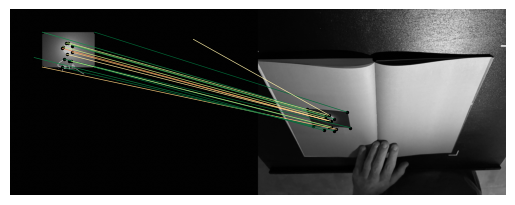

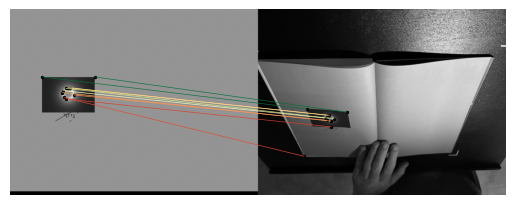

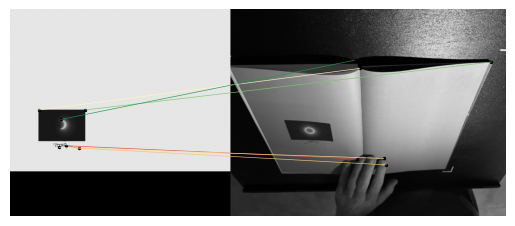

tensor([0.9252, 0.9935, 0.4567, 0.5982, 0.7334, 0.9193, 0.6275, 0.2655, 0.3468,
        0.4302, 0.9472, 0.9818, 0.9138, 0.6242, 0.3708, 0.9956, 0.9832])
tensor(10.2429)


In [81]:
def pp_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = Image.fromarray(img).convert('RGB')
    return img

ref_path = '../static/chapter_ref/'
ref_files = ["darkness.jpeg", "discover.jpeg", "enlightenment.jpeg"]
ref_imgs = [os.path.join(ref_path, f) for f in ref_files]

ref_pils = [pp_img(r) for r in ref_imgs]
img2 = pp_img('../static/data/img/8199.jpeg')
# flip image 180 degrees
img2 = img2.rotate(180)

# create pairs of reference images with the sample image
pairs = [[r, img2] for r in ref_pils]

inputs = processor(pairs, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
sizes = [
            [(ref.height, ref.width), (query.height, query.width)]
            for ref, query in pairs
]
formatted_outputs = processor.post_process_keypoint_matching(outputs, sizes)

processor.plot_keypoint_matching(pairs, formatted_outputs)
print(formatted_outputs[0]['matching_scores'])
good_matches_mask = formatted_outputs[0]['matching_scores'] > 0.5
good_matches = formatted_outputs[0]['matching_scores'][good_matches_mask]
print(good_matches.sum())

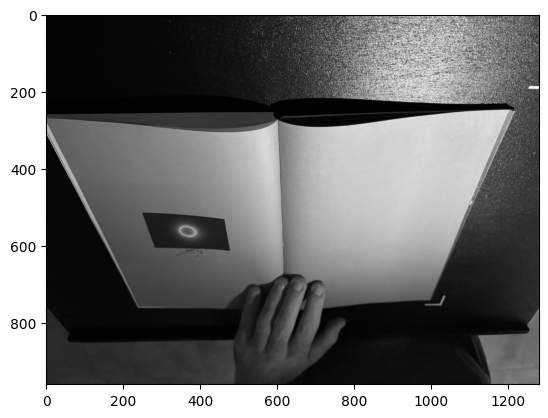

In [44]:
# find contours in the image
sample_feed = cv2.imread('../static/data/img/8199.jpeg')
sample_feed = cv2.rotate(sample_feed, cv2.ROTATE_180)
sample_feed = cv2.cvtColor(sample_feed, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(sample_feed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# find small squares in the contours
small_squares = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < 1000:  # threshold for small squares
        x, y, w, h = cv2.boundingRect(contour)
        small_squares.append((x, y, w, h))

# draw small squares on the image
for (x, y, w, h) in small_squares:
    cv2.rectangle(sample_feed, (x, y), (x + w, y + h), (255, 0, 0), 2)

# plot
plt.imshow(sample_feed, cmap='gray')


In [18]:
inputs['pixel_values'].shape

torch.Size([1, 2, 3, 480, 640])

In [59]:
matching_scores = formatted_outputs[0]["matching_scores"]
num_matches = (matching_scores > 0.3).sum()
k0  = formatted_outputs[0]['keypoints0']
k1 = formatted_outputs[0]['keypoints1']
max_keypoints = max(len(k0), len(k1))
num_matches / max_keypoints if max_keypoints > 0 else 0

tensor(1.)

In [60]:
matching_scores

tensor([0.6863, 0.8666, 0.4522, 0.8173, 0.6369, 0.9895, 0.9945, 0.9891, 0.9751,
        0.9904, 0.9825, 0.9313, 0.8785, 0.9933, 0.9660, 0.9986, 0.9075])

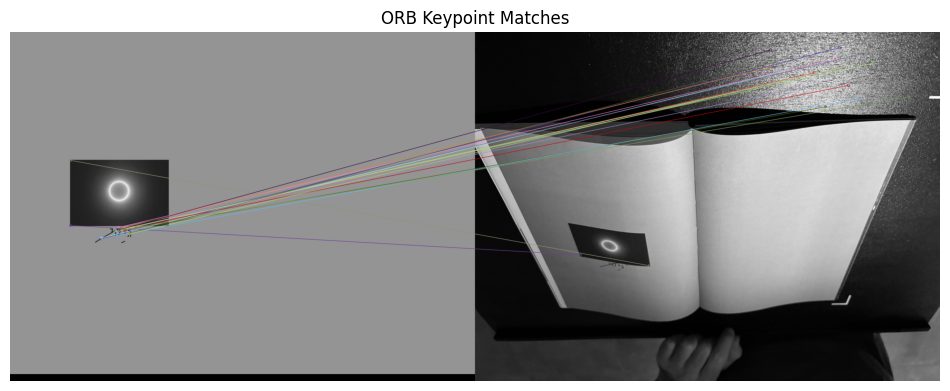

In [39]:
# ORB keypoint detection and matching between two images
img1_path = '../static/chapter_ref/discover.jpeg'
img2_path = '../static/data/img/8200.jpeg'
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
# flip image 180 degrees
img2 = cv2.rotate(img2, cv2.ROTATE_180)

orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 6))
plt.imshow(img_matches, cmap='gray')
plt.title('ORB Keypoint Matches')
plt.axis('off')
plt.show()

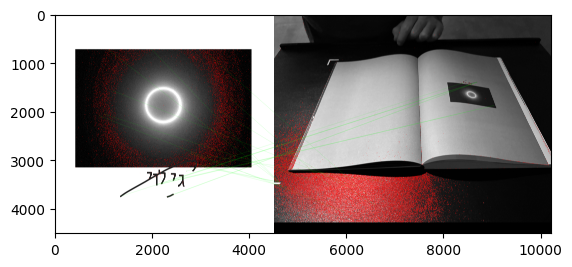

(<matplotlib.image.AxesImage at 0x137b06fd0>, None)

In [88]:
img1_path = '../static/archive/discover.png'
img2_path = '../static/data/img/IMG_8200.jpeg'
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)
 
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
 
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

In [59]:
# test template matching
ref_path = '../static/archive/darkness.png'
frame_path = '../static/data/img/IMG_8211.jpeg'
ref = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
# flip image 180 degrees
img2 = cv2.rotate(img2, cv2.ROTATE_180)
# Resize img1 to match img2 size

# Perform template matching
result = cv2.matchTemplate(img2, img1, cv2.TM_CCOEFF_NORMED)
threshold = 0
y_coords, x_coords = np.where(result >= threshold)
# Draw rectangles around matched areas
for (x, y) in zip(x_coords, y_coords):
    cv2.rectangle(img2, (x, y), (x + img1.shape[1], y + img1.shape[0]), (0, 255, 0), 2)
plt.figure(figsize=(12, 6))
plt.imshow(img2, cmap='gray')
plt.title('Template Matching Result')
plt.axis('off')
plt.show()


error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/templmatch.cpp:1179: error: (-215:Assertion failed) _img.size().height <= _templ.size().height && _img.size().width <= _templ.size().width in function 'matchTemplate'


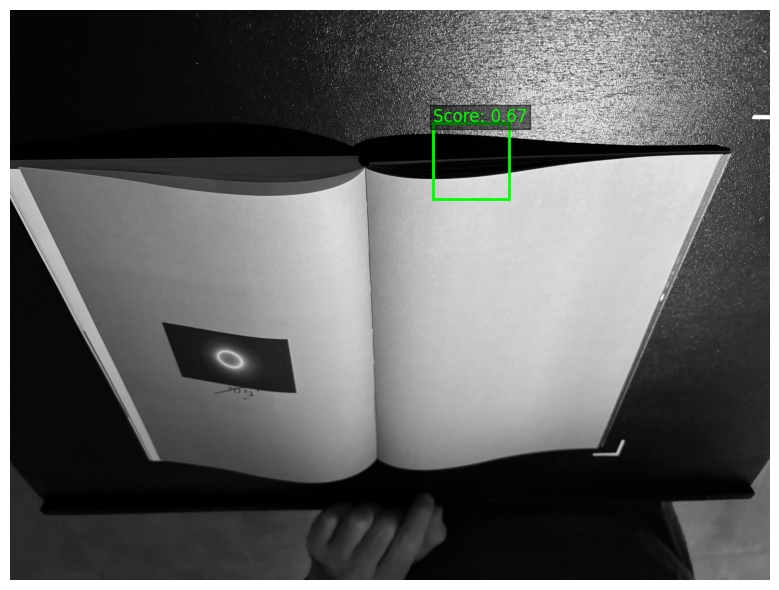

In [78]:
import matplotlib.patches as patches

# test template matching with multiscaling
ref_path = '../static/archive/discover.png'
frame_path = '../static/data/img/IMG_8200.jpeg'
ref = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
# flip frame image 180 degrees
frame = cv2.rotate(frame, cv2.ROTATE_180)

frame_w = frame.shape[1]
aspect_ratio = ref.shape[0] / ref.shape[1]

best_val = -1
best_loc = None
best_size = None
best_ref_resized = None

# Try multiple scales
for scale in range(10, 1, -2):  # from frame_w/10 up to frame_w/2, step by frame_w/scale
    ref_w = int(frame_w / scale)
    ref_h = int(ref_w * aspect_ratio)
    ref_resized = cv2.resize(ref, (ref_w, ref_h), interpolation=cv2.INTER_AREA)
    result = cv2.matchTemplate(frame, ref_resized, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    if max_val > best_val:
        best_val = max_val
        best_loc = max_loc
        best_size = (ref_w, ref_h)
        best_ref_resized = ref_resized

top_left = best_loc
w, h = best_size
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(frame_rgb)
rect = patches.Rectangle(top_left, w, h, linewidth=2, edgecolor='lime', facecolor='none')
ax.add_patch(rect)
ax.text(top_left[0], top_left[1] - 10, f"Score: {best_val:.2f}", fontsize=12, color='lime',
        bbox=dict(facecolor='black', alpha=0.5, pad=2))
ax.axis('off')
plt.tight_layout()
plt.show()

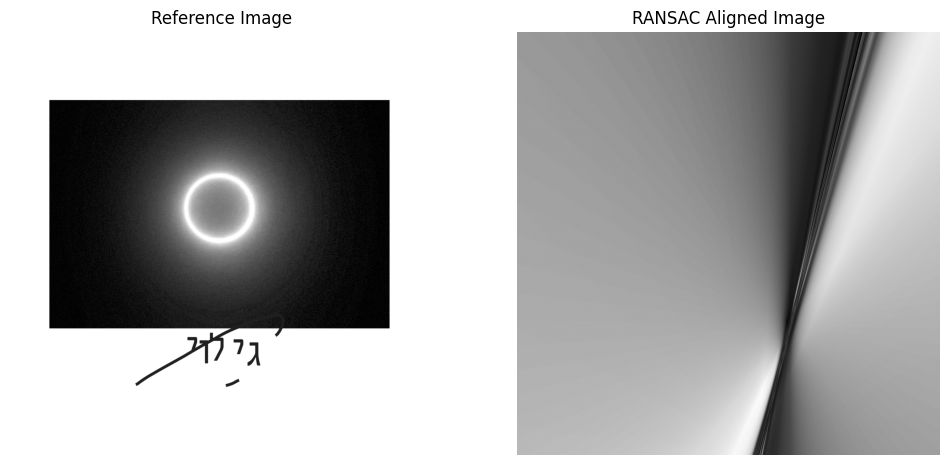

In [79]:
# test ransac algorithm
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load images
frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
ref = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
# flip frame image 180 degrees
frame = cv2.rotate(frame, cv2.ROTATE_180)
# Resize images to the same size if needed

orb = cv2.ORB_create()
# Find the keypoints and descriptors with ORB
frame_kp, frame_des = orb.detectAndCompute(frame, None)
ref_kp, ref_des = orb.detectAndCompute(ref, None)
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors
matches = bf.match(frame_des, ref_des)
# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)
# Extract location of good matches
frame_pts = np.float32([frame_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
ref_pts = np.float32([ref_kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
# Find homography using RANSAC
# Note: cv2.RANSAC is used to robustly estimate the homography
homography, mask = cv2.findHomography(frame_pts, ref_pts, cv2.RANSAC, 5.0)
# Use the homography to warp the frame image
# Note: The size of the output image is set to the size of the reference image
# Note: cv2.warpPerspective is used to apply the homography
aligned_frame = cv2.warpPerspective(frame, homography, (ref.shape[1],ref.shape[0]), flags=cv2.INTER_LINEAR)    
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ref, cmap='gray')
plt.title('Reference Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(aligned_frame, cmap='gray')
plt.title('RANSAC Aligned Image')
plt.axis('off')
plt.show()
